In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # heatmap plots
#import jax.numpy as jnp
#from jax import grad  # automatic differentiation
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier  # neural network from sckikit-learn for comparision
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from part_b_activation import relu, lrelu, sigmoid
import warnings  

#warnings.simplefilter("ignore", ConvergenceWarning)  # ignore convergence warnings from sklearn
warnings.filterwarnings('ignore')

# Set up design matrix and target vector
data = load_breast_cancer()
X = data.data
target = data.target

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.2)

X = X_train
target = target_train.reshape(-1, 1)

In [35]:
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

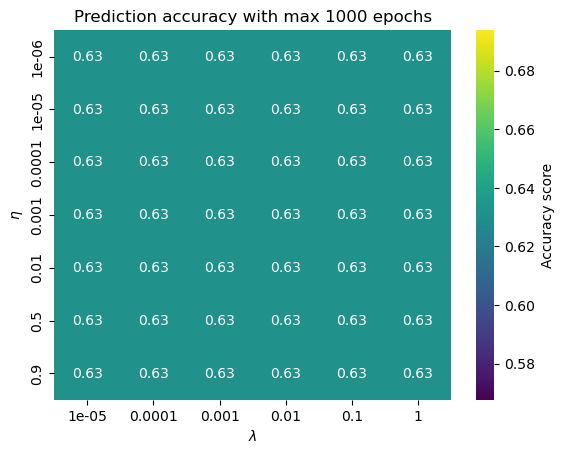

In [46]:
# Parameters
n_hidden_nodes = 50  # hidden nodes per layer
n_categories = 1  # output nodes
n_inputs, n_features = X.shape  # a inputs, b features
delta = 0.7 # Slope for the leaky RELU function


# Activation function 
def activation(x, activation_func):
    # Use sigmoid function:
    if activation_func=="Sigmoid":
        return 1 / (1 + np.exp(-x))
    
    # Use RELU function
    if activation_func=="RELU":
        return np.where(x > np.zeros(x.shape), x, np.zeros(x.shape))
        
    # Use leaky RELU
    if activation_func=="lRELU":
        global delta
        return np.where(x > np.zeros(x.shape), x, delta * x)


# Initialize random number generator with seed
rng = np.random.default_rng(2023)

# Weights and bias in the hidden layer
hidden_weights = rng.standard_normal((n_features, n_hidden_nodes))  # weights normally distributed
hidden_bias = np.zeros(n_hidden_nodes) + 0.01

# Weights and bias in the output layer
output_weights = rng.standard_normal((n_hidden_nodes, n_categories))  # weights normally distributed
output_bias = np.zeros(n_categories) + 0.01

"""
print("Before back propagation:\n")
print("Output weights and bias:")
print(output_weights)
print(output_bias)

print()
print("Hidden weights and bias:")
print(hidden_weights)
print(hidden_bias)
""";
# FEED FORWARD 

def feed_forward(X, activation_func):
    """Feed forward algorithm for one hidden layer"""
    # Weighted sum of inputs to the hidden layer
    z_h = X @ hidden_weights + hidden_bias

    # Activation in the hidden layer
    a_h = activation(z_h, activation_func)

    # Weighted sum of inputs to the output layer
    z_o = a_h @ output_weights + output_bias

    # Activation of output layer; contains the output probabilities
    probabilities = activation(z_o, activation_func)  # this is a_o
    return a_h, probabilities


@np.vectorize
def predict(probability):
    """Get prediction from array with floats. Step function."""
    if not isinstance(probability, (int, float)):
        raise ValueError(f"Probability must be a number, int or float. Got {type(probability)}")
    if probability < 0.5:
        return 0
    else:
        return 1

"""
# Make prediction and compare with gate target y_vectors
a_h, probabilities = feed_forward(X)
predictions = predict(probabilities)

print("Target:")
print(target),

print("\nProbabilities:")
print(probabilities)

print("\nPrediction:")
print(predictions)
""";

def analytic_error_L(target, a, activation_func):
    """Analytical expression for output layer error"""

    if activation_func == "Sigmoid":
        return a - target
        
    if activation_func == "RELU":
        a[a < 0] = 0
        a[a > 0] = 1
        return a * (a - target)/(a * (1 - a))

    if activation_func == "lRELU":
        global delta

        a[a < 0] = delta
        a[a > 0] = 1
        return a * (a - target)/(a * (1 - a))
        

def dfdx(a, activation_func):
    """Rewritten expression of the derivative for the activation function"""
    
    if activation_func == "Sigmoid":
        return a * (1 - a)

    if activation_func == "RELU":
        a[a < 0] = 0
        a[a > 0] = 1
        return a

    if activation_func == "lRELU":
        global delta

        a[a < 0] = delta
        a[a > 0] = 1
        return a

# BACK PROPAGATION 

def back_propagate(X, target, activation_func):
    """Back propagation algorithm for one hidden layer"""
    a_h, probabilities = feed_forward(X, activation_func)

    # Output layer error delta^L using analytical expression
    error_o = analytic_error_L(target, probabilities, activation_func)

    # Hidden layer error delta^1
    error_h = error_o @ output_weights.T * dfdx(a_h, activation_func)

    # Gradients for the hidden layer
    hidden_weights_gradient = X.T @ error_h
    hidden_bias_gradient = np.sum(error_h, axis=0)

    # Gradients for the output layer
    output_weights_gradient = a_h.T @ error_o
    output_bias_gradient = np.sum(error_o, axis=0)

    return hidden_weights_gradient, hidden_bias_gradient, output_weights_gradient, output_bias_gradient


def reset():
    """Resets hidden layer's and output layer's weights and biases to random values"""
    # Weights and bias in the hidden layer
    global hidden_weights, hidden_bias
    hidden_weights = rng.standard_normal((n_features, n_hidden_nodes))  # weights normally distributed
    hidden_bias = np.zeros(n_hidden_nodes) + 0.01

    # Weights and bias in the output layer
    global output_weights, output_bias
    output_weights = rng.standard_normal((n_hidden_nodes, n_categories))  # weights normally distributed
    output_bias = np.zeros(n_categories) + 0.01


# TRAINING THE NEURAL NETWORK UNTILL CONVERGENCE

# We use the gradients from the back propagation algorithm, then we update the weights and biases 
# with the learning rate eta. We also add a regularization hyperparameter lambda to hopefully improve performance. 
# We do a convergence check on all weights and biases to stop the training.

# Here we use plain gradient descent with fixed learning rate for updating the weights and biases.

def train(X, target, eta, lmbd, activation_func, max_epochs=1000, abs_tol=1e-5, prnt=True):
    """Trains the neural network by back propagation until convergence with a given tolerance or until a max number of epoch iterations."""
    w_h = hidden_weights
    b_h = hidden_bias
    w_o = output_weights
    b_o = output_bias
    
    for i in range(max_epochs):
        # Feed forward and back propagate to get all gradients for each epoch
        dW_h, dB_h, dW_o, dB_o = back_propagate(X, target, activation_func)

        # Regularization term
        dW_h += lmbd * w_h
        dW_o += lmbd * w_o

        # Get total changes for convergence check
        change_w_h = eta * dW_h
        change_b_h = eta * dB_h
        change_w_o = eta * dW_o
        change_b_o = eta * dB_o

        # Convergence check: check if epoch changes are small enough
        if all(
                (
                        np.all(abs(change_w_h) <= abs_tol),
                        np.all(abs(change_b_h) <= abs_tol),
                        np.all(abs(change_w_o) <= abs_tol),
                        np.all(abs(change_b_o) <= abs_tol)
                )
        ):
            if prnt:
                print(f"Training converged after {i} epochs.\n")
            return

        # Update weights and biases
        w_h -= change_w_h
        b_h -= change_b_h
        w_o -= change_w_o
        b_o -= change_b_o

    if prnt:
        print(f"Training did not converge after {max_epochs=}.\n")

# FINDING THE BEST COMBINATION OF HYPERPARAMETERS BY GRID SEARCH

# Parameters
eta_vals = np.array([0.01, 0.05, 0.1, 0.5, 0.9])  # learning rates
eta_vals = np.array([0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.5, 0.9])  # learning rates
lmbd_vals = np.logspace(-5, 0, 6) # regularization rates
n_epochs = 1000  # epochs for training
activation_func_type = "lRELU" # type of activation function from selection ["Sigmoind", "RELU", "lRELU"]

# Iterate through parameters -> train -> save accuracy score to heatmap
accuracy = np.zeros((eta_vals.size, lmbd_vals.size))
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        reset()
        train(X, target, eta, lmbd, activation_func=activation_func_type, max_epochs=1000, prnt=False)
        prediction = predict(feed_forward(X, activation_func_type)[-1])
        accuracy[i, j] = accuracy_score(target, prediction)

# Accuracy score heatmap
sns.heatmap(
        accuracy,
        annot=True,
        fmt=".2f",
        xticklabels=[f"{lmbd:g}" for lmbd in lmbd_vals],
        yticklabels=[f"{eta:g}" for eta in eta_vals],
        cbar_kws={"label": "Accuracy score"},
        # cmap="RdBu",
        cmap="viridis",
)
plt.title(f"Prediction accuracy with max {n_epochs} epochs")
plt.xlabel("$\lambda$")
plt.ylabel("$\eta$");
plt.savefig(FIGURES_DIR / f"part_d_grid_1_layer_{n_hidden_nodes}_nodes_{activation_func_type}_activation.png")

We see this prediction does not match any target. This is because we only did one pass and that was with random starting weights. Now we setup the cost function and the back propagation algorithm.


### Applying the best hyperparameters

In [20]:
reset()

# applying the best parameters to the test data
X = X_test
target = target_test.reshape(-1, 1)

# Parameters
eta = 0.00001  # learning rate
lmbd = 0.1  # regularization rate

n_epochs = 1000  # max no. epochs for training
activation_func_type = "Sigmoid" # type of activation function from selection ["Sigmoid", "RELU", "lRELU"]

# Training the model with optimal parameters
train(X, target, eta, lmbd, activation_func=activation_func_type, max_epochs=1000, prnt=False)

"""
print()
print("After training:")
print("Output weights and bias:")
print(output_weights)
print(output_bias)

print("\nHidden weights and bias:")
print(hidden_weights)
print(hidden_bias)

print("\nTarget:")
print(target)
"""

#print("\nProbabilities:")
probabilities = feed_forward(X, activation_func_type)[-1]
#print(probabilities)

#print("\nPrediction:")
prediction = predict(probabilities)
#print(prediction)

print("\nAccuracy score of prediction:")
print(accuracy_score(target, prediction))
print("---------------------------------")



Accuracy score of prediction:
0.6929824561403509
---------------------------------


### Comparing with Sckit-Learn
I do the exact same grid search analysis, but using Scikit-learns MLPClassifier

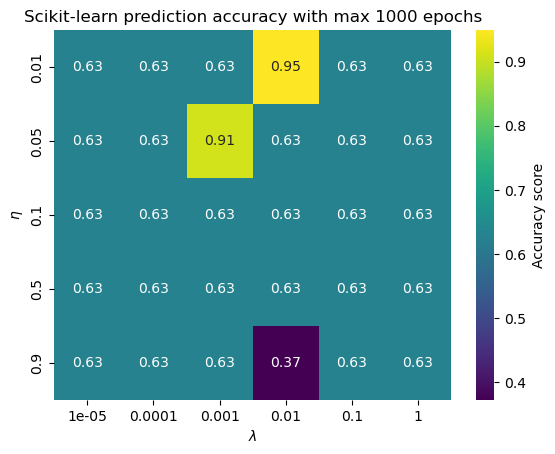

In [102]:
# Parameters
eta_vals = np.array([0.01, 0.05, 0.1, 0.5, 0.9])  # learning rates
lmbd_vals = np.logspace(-5, 0, 6) # regularization rates
#target = yXOR  # choose which target gate to train on [yOR / yAND / yXOR]
target = data.target.reshape(-1, 1)
n_epochs = 1000  # epochs for training

# Iterate through parameters -> train -> save accuracy score to heatmap
accuracy = np.zeros((eta_vals.size, lmbd_vals.size))
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        model = MLPClassifier(hidden_layer_sizes=n_hidden_nodes, activation='logistic',
                              alpha=lmbd, learning_rate_init=eta, max_iter=n_epochs)
        model.fit(X, target.ravel())
        prediction = model.predict(X)
        accuracy[i, j] = accuracy_score(target, prediction)

# Accuracy score heatmap
sns.heatmap(
        accuracy,
        annot=True,
        fmt=".2f",
        xticklabels=[f"{lmbd:g}" for lmbd in lmbd_vals],
        yticklabels=[f"{eta:g}" for eta in eta_vals],
        cbar_kws={"label": "Accuracy score"},
        # cmap="RdBu",
        cmap="viridis",
)
plt.title(f"Scikit-learn prediction accuracy with max {n_epochs} epochs")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\eta$");

Comparing the two heatmaps we see the scikit-learn's implementation has much better accuracy. This is because it uses the ADAM gradient descent method. 